In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import plotly.express as px
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
import matplotlib.pyplot as plt
import folium


# Gradient Boosting 

XGBoost is a popular implementation of Gradient Boosting because its efficient and flexible. XGBoost is designed to for speed and performance primarily through the utilization of tree pruning and lazy loading. 
XGboost incorporates both L2 and L1 regularization which helps to prevent overfitting. (However this requires the right configuration, especially for small datasets hyperparmeters like the tree characteristics and regularization parameter need carefull adjustment)

As with many ensemble methods, the complexity of the model make ith quite diffucult to interpret. 



## Most important Hyperparameters

*learning_rate* : 
This hyperparameter controls the step size at each iteration of the boosting process. A lower learning rate can make the model converge more slowly but can lead to better generalization and prevent overfitting. On the other hand, a higher learning rate can make the model converge faster but may result in overfitting.

*min_child_weight* : 
This hyperparameter determines the minimum sum of instance weight needed in a child. It is used to prevent overfitting by controlling the complexity of the model. A higher value of min_child_weight will create simpler trees with fewer splits.

*max_depth* :
This hyperparameter sets the maximum depth of a tree in the XGBoost model. It controls the complexity of the model and helps prevent overfitting. A higher value of max_depth allows the model to capture more complex relationships in the data but can also lead to overfitting if set too high.

*max_leaf_nodes* : 
This hyperparameter sets the maximum number of leaf nodes in a tree. It limits the complexity of the model by controlling the number of splits. A lower value of max_leaf_nodes results in a simpler model with fewer splits.

*n_estimators*:
This hyperparameter determines the number of gradient boosted trees to be used in the XGBoost model. More trees can result in better learning performance, but too many can lead to overfitting.

*subsample*:
This hyperparameter controls the fraction of the total training set that will be used for each boosting round. A value less than 1.0 can lead to a reduction in variance and overfitting.

*colsample_bytree*:
This hyperparameter determines the fraction of columns to be randomly sampled for each tree. Lower values can prevent overfitting, but too small values might lead to under-fitting.

*gamma*:
This hyperparameter controls the minimum loss reduction required to make a further partition on a leaf node of the tree. It acts as a regularization parameter, with larger values leading to more conservative models.

*reg_lambda* and *reg_alpha*:
These are L2 and L1 regularization terms on weights, respectively. Increasing these values will make the model more conservative.

These hyperparameters play a crucial role in controlling the complexity, generalization, and overfitting of an XGBoost Regressor model. It is important to carefully tune these hyperparameters to achieve the best performance and balance between underfitting and overfitting.


# 1. Read Data

In [3]:
df = pd.read_csv('../data/perth_house_prices.csv')
df = pd.DataFrame(df)
df.head()

,ADDRESS,SUBURB,PRICE,BEDROOMS,BATHROOMS,GARAGE,LAND_AREA,FLOOR_AREA,BUILD_YEAR,CBD_DIST,NEAREST_STN,NEAREST_STN_DIST,DATE_SOLD,POSTCODE,LATITUDE,LONGITUDE,NEAREST_SCH,NEAREST_SCH_DIST,NEAREST_SCH_RANK
0,1 Acorn Place,South Lake,565000,4,2,2.0,600,160,2003.0,18300,Cockburn Central Station,1800,09-2018\r,6164,-32.115900,115.842450,LAKELAND SENIOR HIGH SCHOOL,0.828339,NaN
1,1 Addis Way,Wandi,365000,3,2,2.0,351,139,2013.0,26900,Kwinana Station,4900,02-2019\r,6167,-32.193470,115.859554,ATWELL COLLEGE,5.524324,129.0
2,1 Ainsley Court,Camillo,287000,3,1,1.0,719,86,1979.0,22600,Challis Station,1900,06-2015\r,6111,-32.120578,115.993579,KELMSCOTT SENIOR HIGH SCHOOL,1.649178,113.0
3,1 Albert Street,Bellevue,255000,2,1,2.0,651,59,1953.0,17900,Midland Station,3600,07-2018\r,6056,-31.900547,116.038009,SWAN VIEW SENIOR HIGH SCHOOL,1.571401,NaN
4,1 Aman Place,Lockridge,325000,4,1,2.0,466,131,1998.0,11200,Bassendean Station,2000,11-2016\r,6054,-31.885790,115.947780,KIARA COLLEGE,1.514922,NaN


In [4]:
print(f"DataFrame Shape: {df.shape}")

DataFrame Shape: (33656, 19)


In [5]:
df.columns

Index(['ADDRESS', 'SUBURB', 'PRICE', 'BEDROOMS', 'BATHROOMS', 'GARAGE',
       'LAND_AREA', 'FLOOR_AREA', 'BUILD_YEAR', 'CBD_DIST', 'NEAREST_STN',
       'NEAREST_STN_DIST', 'DATE_SOLD', 'POSTCODE', 'LATITUDE', 'LONGITUDE',
       'NEAREST_SCH', 'NEAREST_SCH_DIST', 'NEAREST_SCH_RANK'],
      dtype='object')

## 1.1 EDA

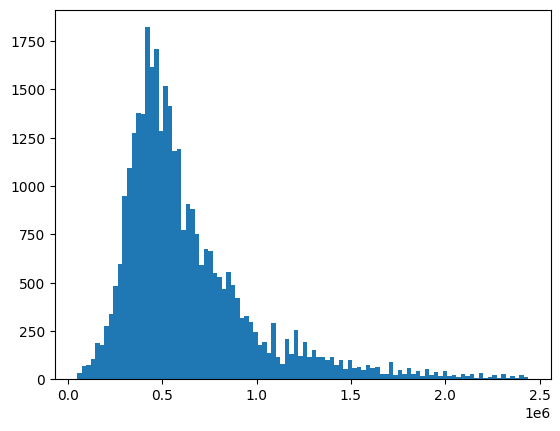

In [7]:
plt.hist(df['PRICE'], bins=100)
plt.show()

In [13]:
# Show single house location
# You can incease the size of the sample but be aware that the map will be slow to load and the notebook might not be able to render it
# This will also not be rendered in the github preview so you will need to run the notebook locally to see the map

random_idx = np.random.randint(0, len(df), 1)
random_idx = random_idx[0]

m = folium.Map(location=[df['LATITUDE'][random_idx], df['LONGITUDE'][random_idx]], zoom_start=15)
folium.Marker([df['LATITUDE'][random_idx], df['LONGITUDE'][random_idx]], popup=f"Price: {df['PRICE'][random_idx]}").add_to(m)

m 


# 2. Preprocessing

In the next step its now important to identify which columns are usefull features. 
There are two important considerations: 
- Cardinality or the Number of Unique Values in a column. For example the Id column is unique for each row and therefore has no influence to the prediction. Encoding high cardinailty features is also computationally more costly
- Null Values - Columns with a high number of Null Values are not usefull and might as well be dropped completly 

## 2.1 Identify Null Values

In [14]:
# Identify the columns with missing values and the percentage of missing values
df.isna().sum()/ len(df) * 100

ADDRESS              0.000000
SUBURB               0.000000
PRICE                0.000000
BEDROOMS             0.000000
BATHROOMS            0.000000
GARAGE               7.362729
LAND_AREA            0.000000
FLOOR_AREA           0.000000
BUILD_YEAR           9.374257
CBD_DIST             0.000000
NEAREST_STN          0.000000
NEAREST_STN_DIST     0.000000
DATE_SOLD            0.000000
POSTCODE             0.000000
LATITUDE             0.000000
LONGITUDE            0.000000
NEAREST_SCH          0.000000
NEAREST_SCH_DIST     0.000000
NEAREST_SCH_RANK    32.541003
dtype: float64

In [15]:
df['GARAGE'].value_counts()

GARAGE
2.0     20724
1.0      5290
3.0      2042
4.0      1949
6.0       466
5.0       362
8.0       129
7.0        97
12.0       30
10.0       26
9.0        17
14.0       13
13.0        8
11.0        7
16.0        4
18.0        3
20.0        3
32.0        1
17.0        1
21.0        1
99.0        1
26.0        1
22.0        1
50.0        1
31.0        1
Name: count, dtype: int64

In [16]:
# Fill missing values with 0
df['GARAGE'] = df['GARAGE'].fillna(0)

In [19]:
# Fill missing values with the median
df['BUILD_YEAR'] = df['BUILD_YEAR'].fillna(df['BUILD_YEAR'].median())

In [20]:
# Fill missing values with the median
# I presonally prefer to use the median for filling missing values in the target column rather than the mean because the median is less sensitive to outliers
df['NEAREST_SCH_RANK'] = df['NEAREST_SCH_RANK'].fillna(df['NEAREST_SCH_RANK'].median())

In [21]:
df.nunique()

ADDRESS             33566
SUBURB                321
PRICE                2297
BEDROOMS               10
BATHROOMS               8
GARAGE                 26
LAND_AREA            4372
FLOOR_AREA            528
BUILD_YEAR            124
CBD_DIST              595
NEAREST_STN            68
NEAREST_STN_DIST     1189
DATE_SOLD             350
POSTCODE              114
LATITUDE            29707
LONGITUDE           28557
NEAREST_SCH           160
NEAREST_SCH_DIST    33318
NEAREST_SCH_RANK      103
dtype: int64

In [22]:
df.columns

Index(['ADDRESS', 'SUBURB', 'PRICE', 'BEDROOMS', 'BATHROOMS', 'GARAGE',
       'LAND_AREA', 'FLOOR_AREA', 'BUILD_YEAR', 'CBD_DIST', 'NEAREST_STN',
       'NEAREST_STN_DIST', 'DATE_SOLD', 'POSTCODE', 'LATITUDE', 'LONGITUDE',
       'NEAREST_SCH', 'NEAREST_SCH_DIST', 'NEAREST_SCH_RANK'],
      dtype='object')

In [23]:
df_numerical = df.select_dtypes(include=['int64', 'float64'])
df_numerical.nunique()

PRICE                2297
BEDROOMS               10
BATHROOMS               8
GARAGE                 26
LAND_AREA            4372
FLOOR_AREA            528
BUILD_YEAR            124
CBD_DIST              595
NEAREST_STN_DIST     1189
POSTCODE              114
LATITUDE            29707
LONGITUDE           28557
NEAREST_SCH_DIST    33318
NEAREST_SCH_RANK      103
dtype: int64

In [24]:
df_categorical = df.select_dtypes(include=['object']) 
df_categorical.nunique()

ADDRESS        33566
SUBURB           321
NEAREST_STN       68
DATE_SOLD        350
NEAREST_SCH      160
dtype: int64

In [25]:
df_num_features = df_numerical.drop(columns=['LATITUDE', 'LONGITUDE', 'NEAREST_SCH_DIST', 'PRICE'])
df_cat_features = df_categorical.drop(columns=['ADDRESS'])

TARGET = 'PRICE'

# 2. Preprocessing

In [26]:
df_dummies = pd.get_dummies(df_cat_features, drop_first=True)
df_dummies.head()

,SUBURB_Alfred Cove,SUBURB_Alkimos,SUBURB_Anketell,SUBURB_Applecross,SUBURB_Ardross,SUBURB_Armadale,SUBURB_Ascot,SUBURB_Ashby,SUBURB_Ashfield,SUBURB_Attadale,...,NEAREST_SCH_TRINITY COLLEGE,NEAREST_SCH_URSULA FRAYNE CATHOLIC COLLEGE,NEAREST_SCH_WANNEROO SECONDARY COLLEGE,NEAREST_SCH_WARNBRO COMMUNITY HIGH SCHOOL,NEAREST_SCH_WARWICK SENIOR HIGH SCHOOL,NEAREST_SCH_WESLEY COLLEGE,NEAREST_SCH_WILLETTON SENIOR HIGH SCHOOL,NEAREST_SCH_WOODVALE SECONDARY COLLEGE,NEAREST_SCH_YANCHEP SECONDARY COLLEGE,NEAREST_SCH_YOUTH FUTURES COMMUNITY SCHOOL
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [27]:
df_num_features.shape

(33656, 10)

In [28]:
X_num = df_num_features
X_scaler = StandardScaler()
X_scaled = X_scaler.fit_transform(X_num.values.reshape(-1, 10))
X_scaled = pd.DataFrame(X_scaled, columns=X_num.columns)

y_scaler = StandardScaler()
y_scaled = y_scaler.fit_transform(df[TARGET].values.reshape(-1, 1))
y_scaled = pd.DataFrame(y_scaled, columns=[TARGET])

X  = pd.concat([X_scaled, df_dummies], axis=1)
y = y_scaled

# 3. Model

In [29]:
params = {
                'colsample_bytree': [0.3, 0.7],
                'learning_rate': [0.01, 0.1],
                'max_depth': [3, 5],
                'alpha': [10, 50],
                'n_estimators': [100, 200],
                'subsample': [0.5, 0.8],
                'gamma': [0, 10],
                'min_child_weight': [1, 5],
                'lambda': [10, 50],
              }
    

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xg_reg = XGBRegressor(objective='reg:squarederror', eval_metric='rmse')
xgb_search = RandomizedSearchCV(estimator=xg_reg, param_distributions=params, cv=3, n_iter=20, verbose=0, n_jobs=-1)
xgb_search.fit(X_train, y_train)

best_params = xgb_search.best_params_
best_model = xgb_search.best_estimator_

y_pred = best_model.predict(X_test)
pred_scaled = pd.DataFrame(y_pred, columns=['PRICE'])
y_pred_inv = y_scaler.inverse_transform(pred_scaled)
y_test_inv = y_scaler.inverse_transform(y_test)

mse = mean_squared_error(y_test_inv, y_pred_inv)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test, y_pred)
r2, mae

/Users/maximilianruess/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


(0.7813812016174579, 104192.78846368093)

In [31]:
# Training using ML Flow
import mlflow
import mlflow.sklearn

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xg_reg = XGBRegressor(objective='reg:squarederror', eval_metric='rmse')
xgb_search = RandomizedSearchCV(estimator=xg_reg, param_distributions=params, cv=3, n_iter=20, verbose=0, n_jobs=-1)

with mlflow.start_run():
    xgb_search.fit(X_train, y_train)

    best_params = xgb_search.best_params_
    best_model = xgb_search.best_estimator_

    y_pred = best_model.predict(X_test)
    pred_scaled = pd.DataFrame(y_pred, columns=['PRICE'])
    y_pred_inv = y_scaler.inverse_transform(pred_scaled)
    y_test_inv = y_scaler.inverse_transform(y_test)

    mse = mean_squared_error(y_test_inv, y_pred_inv)
    mae = mean_absolute_error(y_test_inv, y_pred_inv)
    r2 = r2_score(y_test, y_pred)

    # Log parameters
    mlflow.log_params(best_params)

    # Log metrics
    mlflow.log_metric("mse", mse)
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("r2", r2)

    # Log model
    mlflow.sklearn.log_model(best_model, "model")

/Users/maximilianruess/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


## Feature Importance

In [32]:
# Feature Importance

feature_importance = best_model.feature_importances_
features = X.columns
df_feature_importance = pd.DataFrame({'features': features, 'importance': feature_importance})
df_feature_importance = df_feature_importance.sort_values(by='importance', ascending=False)
df_feature_importance

,features,importance
845,NEAREST_SCH_NEWMAN COLLEGE,0.088039
9,NEAREST_SCH_RANK,0.062407
1,BATHROOMS,0.058769
223,SUBURB_Nedlands,0.054645
4,FLOOR_AREA,0.053328
...,...,...
341,NEAREST_STN_Challis Station,0.000000
342,NEAREST_STN_City West Station,0.000000
343,NEAREST_STN_Claisebrook Station,0.000000
344,NEAREST_STN_Claremont Station,0.000000


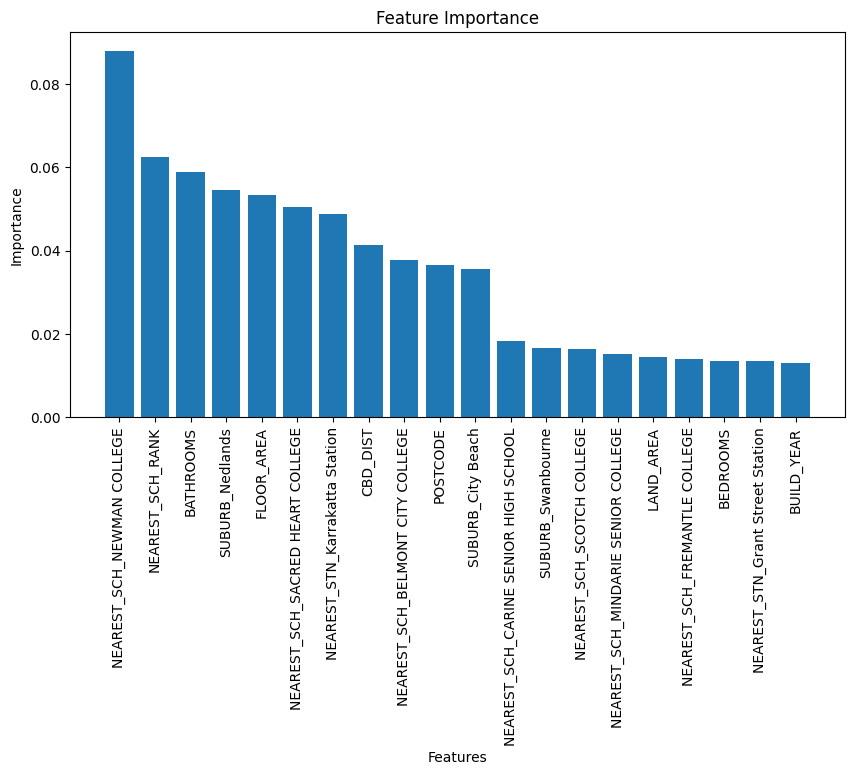

In [36]:
# plot feature importance
plt.figure(figsize=(10, 5))
plt.bar(df_feature_importance['features'].head(20), df_feature_importance['importance'].head(20))
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.xticks(rotation=90)
plt.show()

# 4. Predict on all data

In [37]:
pred = best_model.predict(X)
pred_scaled = pd.DataFrame(pred, columns=['PRICE'])
pred_inv = y_scaler.inverse_transform(pred_scaled)
pred_inv = pd.DataFrame(pred_inv, columns=['PRICE'])

df_new = df.copy()
df_new['PRED_PRICE'] = pred_inv
df_new.head()

,ADDRESS,SUBURB,PRICE,BEDROOMS,BATHROOMS,GARAGE,LAND_AREA,FLOOR_AREA,BUILD_YEAR,CBD_DIST,NEAREST_STN,NEAREST_STN_DIST,DATE_SOLD,POSTCODE,LATITUDE,LONGITUDE,NEAREST_SCH,NEAREST_SCH_DIST,NEAREST_SCH_RANK,PRED_PRICE
0,1 Acorn Place,South Lake,565000,4,2,2.0,600,160,2003.0,18300,Cockburn Central Station,1800,09-2018\r,6164,-32.115900,115.842450,LAKELAND SENIOR HIGH SCHOOL,0.828339,68.0,490575.09375
1,1 Addis Way,Wandi,365000,3,2,2.0,351,139,2013.0,26900,Kwinana Station,4900,02-2019\r,6167,-32.193470,115.859554,ATWELL COLLEGE,5.524324,129.0,367251.53125
2,1 Ainsley Court,Camillo,287000,3,1,1.0,719,86,1979.0,22600,Challis Station,1900,06-2015\r,6111,-32.120578,115.993579,KELMSCOTT SENIOR HIGH SCHOOL,1.649178,113.0,251068.37500
3,1 Albert Street,Bellevue,255000,2,1,2.0,651,59,1953.0,17900,Midland Station,3600,07-2018\r,6056,-31.900547,116.038009,SWAN VIEW SENIOR HIGH SCHOOL,1.571401,68.0,300386.62500
4,1 Aman Place,Lockridge,325000,4,1,2.0,466,131,1998.0,11200,Bassendean Station,2000,11-2016\r,6054,-31.885790,115.947780,KIARA COLLEGE,1.514922,68.0,368617.06250
